# Sheet 6

## 1 Autoencoders: theory and practice

In [1]:
import numpy as np

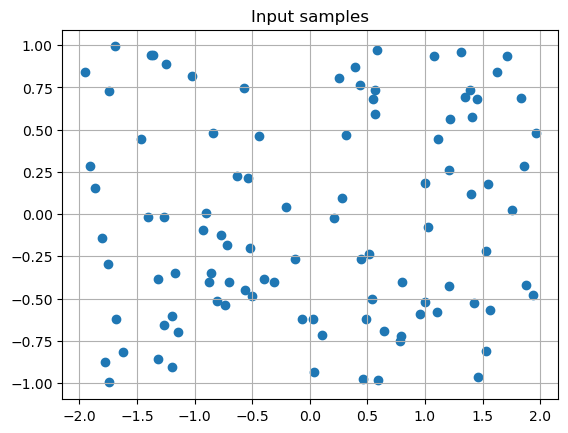

In [2]:
import torch
import matplotlib.pyplot as plt

# create 1000 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [3]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print(x,y)
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

tensor([[-0.5185, -0.1993],
        [ 1.0801,  0.9392],
        [ 1.3905,  0.7348],
        [ 1.5648, -0.5684],
        [ 1.4512,  0.6837],
        [-1.7427,  0.7308],
        [-1.3621,  0.9411],
        [-1.9089,  0.2855]]) tensor([[-0.5185, -0.1993],
        [ 1.0801,  0.9392],
        [ 1.3905,  0.7348],
        [ 1.5648, -0.5684],
        [ 1.4512,  0.6837],
        [-1.7427,  0.7308],
        [-1.3621,  0.9411],
        [-1.9089,  0.2855]])
x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


In [36]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl

class Autoencoder(nn.Module):
    def __init__(self, hidded_channels, latent_dim=1, input_dim=2):
        super().__init__()
        encoder_layers = []
        layer_sizes = np.concatenate((np.array([input_dim]), np.array(hidded_channels), np.array([latent_dim])))
        for i in range(len(layer_sizes) - 1):
            encoder_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # Don't add activation to the last layer
                encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = []
        for i in range(len(layer_sizes) - 1, 0, -1):
            decoder_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i - 1]))
            if i > 1:  # Don't add activation to the last layer
                decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def embedder(self, x):
        x = self.encoder(x)
        return x

class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder.forward(x)
    
    def embedder(self, x):
        x = self.autoencoder.embedder(x)
        return x

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        #print(batch)
        x_hat = self.autoencoder(x)
        #print(x_hat)
        loss = nn.MSELoss()(x_hat, x)
        #print(loss.item())
        self.loss_curve.append(loss.item())
        return loss
    
    

In [58]:
# start the training using a PyTorch Lightning Trainer
def plot_all(hidded_channels, epochs = 1000):
    trainer = pl.Trainer(max_epochs=epochs)
    autoencoder_module = AutoencoderModule( hidded_channels = hidded_channels)
    autoencoder_module.forward
    trainer.fit(autoencoder_module, data_loader)

    loss = autoencoder_module.loss_curve
    latent = autoencoder_module.embedder(data)
    x = data[:,0].detach().numpy()
    y = data[:,1].detach().numpy()
    latent = latent.detach().numpy()

    plt.plot(loss, color = "b")
    plt.title(f"Loss curve for {hidded_channels}")
    plt.show()
    plt.scatter(x, y, c=latent)
    plt.title(f"Latent embedding for {hidded_channels}")
    plt.colorbar()
    plt.show()
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
c:\Users\janre\OneDrive\Studium\MachineLearning\sheet01\.conda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\janre\OneDrive\Studium\MachineLearning\sheet01\.conda\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


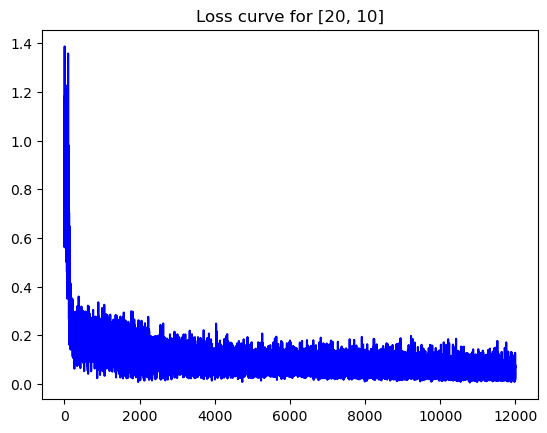

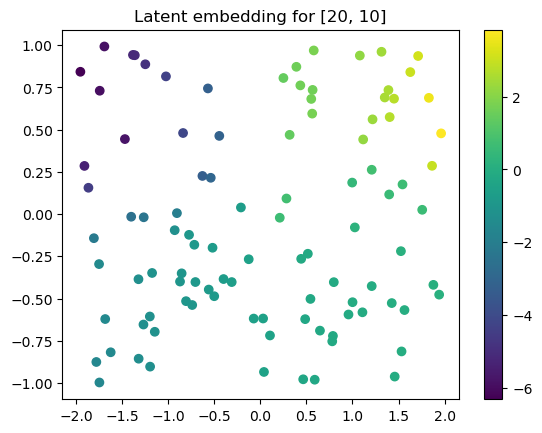

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


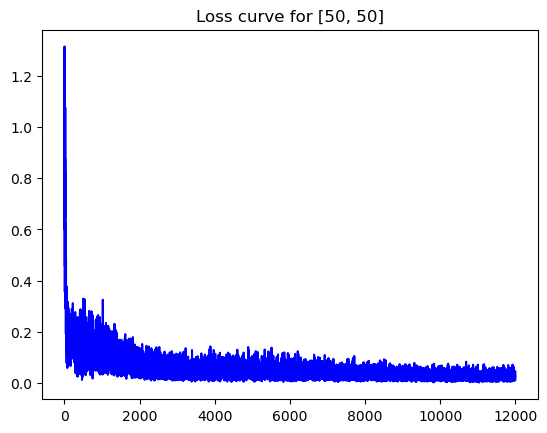

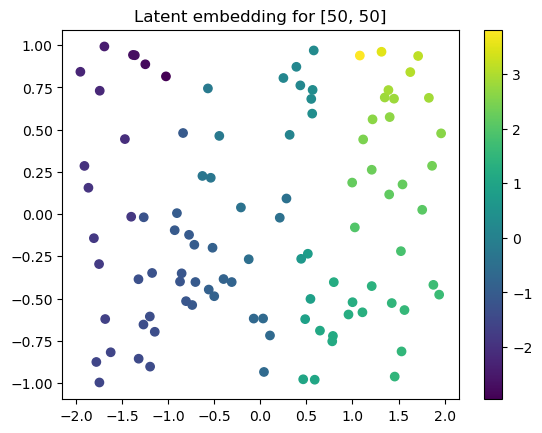

In [60]:
dims = [[20, 10], [50, 50]]
for dim in dims:
    plot_all(dim)

PCA

In [20]:
import torch

def pca(data, num_components):
    
    # Center the data
    mean = torch.mean(data, dim=0)
    centered_data = data - mean
    
    # Compute the covariance matrix
    covariance_matrix = torch.mm(centered_data.T, centered_data) / (data.shape[0] - 1)
    
    # Calculate eigenvalues and eigenvectors using torch.linalg.eig()
    eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
    
    # Convert complex eigenvalues to real (if negligible imaginary parts exist)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    
    # Sort by descending eigenvalues
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top principal components
    components = eigenvectors[:, :num_components]
    projected_data = torch.mm(centered_data, components)
    
    # Explained variance
    explained_variance = eigenvalues[:num_components]
    
    return projected_data, explained_variance, components

# Example: Applying PCA to generated data
num_components = 1
projected_data, explained_variance, components = pca(data, num_components)

print("Projected Data (first 5 samples):", projected_data[:5])


Projected Data (first 5 samples): tensor([[-1.8399],
        [-0.6167],
        [-1.8759],
        [ 0.4803],
        [ 1.3702]])


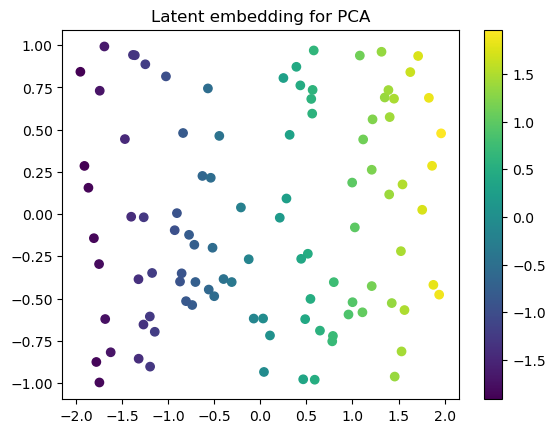

In [57]:
x = data[:,0].detach().numpy()
y = data[:,1].detach().numpy()
latent = projected_data[:, 0].detach().numpy()

plt.scatter(x, y, c=latent)
plt.title("Latent embedding for PCA")
plt.colorbar()
plt.show()

#### c)


##### Autoencoder 1: {20, 10, 1, 10, 20, 2}

i)
- With random initialization of weights, the decoder's mapping will essentially behave like a random function. Sampling points from the latent space will map to arbitrary, irregular curves in the input space. These curves will not follow any discernible structure as no meaningful relationship between the latent and input spaces has been learned.

ii)
- After training, the decoder learns to map latent space points back to the input space in a structured way. Since the bottleneck dimension is 1, the decoder will map the latent interval to a 1D manifold in the 2D input space.
- The manifold will resemble the underlying shape of the input data distribution (e.g., a straight or curved line, depending on the data geometry). The exact shape will depend on the data distribution and how well the autoencoder has learned it.


##### Autoencoder 2: {50, 50, 1, 50, 50, 2}

i)
- Due to the higher number of parameters, the decoder at random initialization will likely produce more complex, erratic, and jagged curves compared to `AE1`. The larger network introduces more random interactions between latent space points and their input space mapping.

ii)
- After training, the mapping from the latent space to the input space will be more flexible and capable of representing complex structures in the data.
- Sampling points from the latent space will map to a 1D manifold, but it may capture finer nuances and non-linearities in the input data compared to `AE1`.


##### PCA Autoencoder

ii)
- At random initialization, the PCA-based architecture will behave like a linear projection with untrained weights. Sampling points from the latent space will map to straight lines or simple affine transformations in the input space. The lack of non-linearities restricts the curve's complexity.

After Training:
- After training, the decoder will map the latent space to a linear subspace in the input space. Sampling an interval from the latent space will produce a straight line segment in the input space.
- This is because PCA inherently learns a linear relationship between the latent and input spaces, so the curve will not bend or follow any non-linear structure.


### Summary of Curves
| Architecture      | Random Initialization                                 | After Training                                   |
|-------------------|------------------------------------------------------|------------------------------------------------|
| **AE1**           | Irregular, erratic curves                            | Smooth 1D manifold resembling input data       |
| **AE2**           | More jagged, complex random curves                   | Flexible, non-linear 1D manifold of input data |
| **PCA Autoencoder** | Straight or affine-transformed lines               | Straight line segment in the input space       |
